In [24]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy.sparse as sparse
import scipy as sp
import pickle

In [25]:
nside = 64
npix = hp.nside2npix(nside)

In [26]:
with open('B_eigs_2000.pkl', 'rb') as handle:
    B_eigs, B_v = pickle.load(handle)

In [27]:
len(np.where(B_v[:,0]>1e-10)[0])

4012

In [31]:
np.dot(B_v[:,-1], B_v[:,-5])

-0.014479038944955391

Text(0.5, 1.0, 'Eigenvalue spectrum (cut-sky) largest 1000')

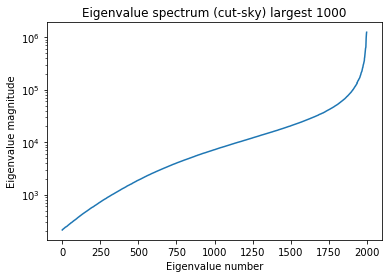

In [5]:
plt.plot(B_eigs)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue magnitude')
plt.title('Eigenvalue spectrum (cut-sky) largest 1000')

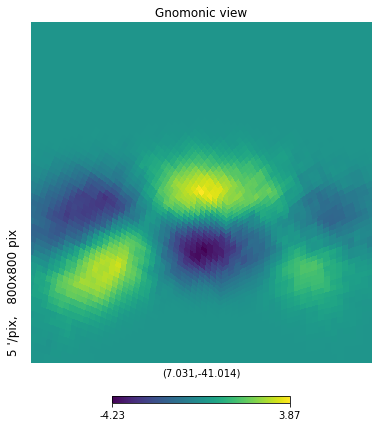

In [7]:
m_vector = B_v[:,-1].reshape(2, npix)[0]

lon,lat = hp.pix2ang(nside, np.argmax(m_vector), lonlat=True)
hp.gnomview(m_vector, rot=(lon, lat), xsize=800, reso=5)

In [3]:
C_E = sparse.load_npz('C_E.npz')
C_B = sparse.load_npz('C_B.npz')

In [7]:
np.where(np.isnan(C_E.diagonal()))[0]

array([196604, 393212])

In [4]:
sigma = np.mean(C_E.diagonal())/1000
print(sigma)
factor = sparse.identity(C_E.shape[0], format='csr') * sigma

nan


In [42]:
#e, v = sparse.linalg.eigs(C_B+factor, 5, C_E+factor, which='LM', return_eigenvectors=True)
e, v = sparse.linalg.eigsh(C_B+factor, 5, C_E+factor, which='LM', return_eigenvectors=True)

In [43]:
e

array([3013721.81931298, 3282853.4269486 , 4101900.77483169,
       5943855.13933581, 6449059.65150727])

In [46]:
v[np.where(abs(v)<1e-10)[0]] = 0

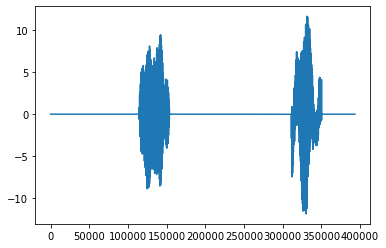

In [47]:
plt.plot(v[:,0])

In [54]:
hp.mollview(v[:,-1].reshape(2, npix)[0])

TypeError: 'coo_matrix' object is not subscriptable

In [50]:
v = sparse.csc_matrix(v)

In [51]:
P = v.dot(sparse.linalg.inv(v.T.dot(v)).dot(v.T))

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [52]:
ep, vp = sparse.linalg.eigsh(P, 5, which='LM', return_eigenvectors=True)

In [53]:
ep

array([1., 1., 1., 1., 1.])

In [23]:
nreal = 10
nside = 128
npix = hp.nside2npix(nside)

In [450]:
mask = hp.read_map('./out_maps/0/lcdm_telescope_all_time_all_invnpp.fits',verbose=False, dtype=np.float64)
mask[np.where(mask!=0)] = 1

X_E = sparse.coo_matrix(np.concatenate(mask*hp.read_map('./pure_maps/E/E_map_0.fits', field=[1,2], verbose=False, dtype=np.float64)))

for i in range(nreal-1):
    in_map = mask*hp.read_map(f'./pure_maps/E/E_map_{i+1}.fits', field=[1,2], verbose=False, dtype=np.float64)
    m_vector = np.concatenate(in_map)
    X_E = sparse.vstack([X_E, m_vector])
    X_E = X_E.tocsr()

In [451]:
X_E

<10x393216 sparse matrix of type '<class 'numpy.float64'>'
	with 33060 stored elements in Compressed Sparse Row format>

In [452]:
def sparse_covariance(X):
    
    if not sparse.issparse(X):
        X = sparse.csr_matrix(X)
        
    n = X.shape[0]
    means = np.array(X.mean(axis=0))[0]
    
#     centering = sparse.csr_matrix(means)

#     for i in range(n-1):
#         centering = sparse.vstack([centering, means])

#     X -= centering
    
    nz = np.where(means!=0)[0]

    for i in nz:
        X[:,i] -= np.ones((n,1))*means[i]
    
    print(np.max(X.mean(axis=0)))

    X = X.transpose()
    C = X.dot(X.transpose())/(n-1)
    
    return C.tocsr()

In [453]:
C = sparse_covariance(X_E)

4.440892098500626e-16


In [454]:
C

<393216x393216 sparse matrix of type '<class 'numpy.float64'>'
	with 10929636 stored elements in Compressed Sparse Row format>

In [455]:
a = np.random.rand(5)
b = np.random.rand(5)
c = np.random.rand(5)
d = np.random.rand(5)

e = np.random.rand(6)
f = np.random.rand(6)
g = np.random.rand(6)
h = np.random.rand(6)

A = np.vstack([a, b, c ,d])
B = np.vstack([e, f, g, h])

n = A.shape[0]


In [299]:
a = np.random.rand(3)
b = np.random.rand(3)
X = np.vstack([a, b])

n = X.shape[0]


In [456]:
np.cov(A, rowvar=False)

array([[ 0.00267082,  0.00176539,  0.00684556,  0.00198344, -0.0002293 ],
       [ 0.00176539,  0.03522566,  0.00169013,  0.0264441 ,  0.03473687],
       [ 0.00684556,  0.00169013,  0.15560605, -0.08397765, -0.04688832],
       [ 0.00198344,  0.0264441 , -0.08397765,  0.07489876,  0.05295919],
       [-0.0002293 ,  0.03473687, -0.04688832,  0.05295919,  0.04942241]])

In [457]:
sparse_covariance(A).toarray()

0.0


array([[ 0.00267082,  0.00176539,  0.00684556,  0.00198344, -0.0002293 ],
       [ 0.00176539,  0.03522566,  0.00169013,  0.0264441 ,  0.03473687],
       [ 0.00684556,  0.00169013,  0.15560605, -0.08397765, -0.04688832],
       [ 0.00198344,  0.0264441 , -0.08397765,  0.07489876,  0.05295919],
       [-0.0002293 ,  0.03473687, -0.04688832,  0.05295919,  0.04942241]])

In [377]:
sparse_X = sparse.csr_matrix(A)
sparse_means = np.array(sparse_X.mean(axis=0))[0]

centering = sparse.csr_matrix(sparse_means)

for i in range(n-1):
    centering = sparse.vstack([centering, sparse_means])

sparse_X -= centering

sparse_X = sparse_X.transpose()
C = sparse_X.dot(sparse_X.transpose())/(n-1)
C.toarray()

array([[ 0.2209869 ,  0.0468735 ,  0.0012988 ,  0.02346509, -0.02992237],
       [ 0.0468735 ,  0.13061846,  0.03895296,  0.07210558,  0.01347292],
       [ 0.0012988 ,  0.03895296,  0.01258877,  0.02323137,  0.01134222],
       [ 0.02346509,  0.07210558,  0.02323137,  0.05331673,  0.05197727],
       [-0.02992237,  0.01347292,  0.01134222,  0.05197727,  0.15173355]])

In [378]:
sparse_X = sparse.csr_matrix(A)
sparse_means = np.array(sparse_X.mean(axis=0))[0]

nz = np.where(sparse_means!=0)[0]

for i in nz:
    sparse_X[:,i] -= np.ones((n,1))*sparse_means[i]

sparse_X = sparse_X.transpose()

C = sparse_X.dot(sparse_X.transpose())/(n-1)
C.toarray()

array([[ 0.2209869 ,  0.0468735 ,  0.0012988 ,  0.02346509, -0.02992237],
       [ 0.0468735 ,  0.13061846,  0.03895296,  0.07210558,  0.01347292],
       [ 0.0012988 ,  0.03895296,  0.01258877,  0.02323137,  0.01134222],
       [ 0.02346509,  0.07210558,  0.02323137,  0.05331673,  0.05197727],
       [-0.02992237,  0.01347292,  0.01134222,  0.05197727,  0.15173355]])

In [303]:
sparse_X = sparse.csr_matrix(X)
sparse_means = np.array(sparse_X.mean(axis=0))[0]
sparse_X = sparse_X - sparse_means 
sparse_X
sparse_X = sparse_X.transpose()
C_A = sparse_X.dot(sparse_X.transpose())/(n-1)
C_A

matrix([[ 0.01303067, -0.0213022 ,  0.00680013],
        [-0.0213022 ,  0.03482427, -0.01111667],
        [ 0.00680013, -0.01111667,  0.00354868]])

In [137]:
sparse_X = sparse.csr_matrix(B)
sparse_means = sparse_X.mean(axis=0)
sparse_X = sparse_X - sparse_means 
sparse_X = sparse_X.transpose()
C_B = sparse_X.dot(sparse_X.transpose())/(n-1)
C_B

matrix([[ 0.09683957,  0.03196201,  0.00701399, -0.01649663, -0.04246677,
          0.05648739],
        [ 0.03196201,  0.06206469,  0.02515747,  0.00219576, -0.01182727,
          0.03323159],
        [ 0.00701399,  0.02515747,  0.0216244 , -0.01448207, -0.01321946,
          0.03924814],
        [-0.01649663,  0.00219576, -0.01448207,  0.02924955,  0.02442584,
         -0.05099663],
        [-0.04246677, -0.01182727, -0.01321946,  0.02442584,  0.02995795,
         -0.05316992],
        [ 0.05648739,  0.03323159,  0.03924814, -0.05099663, -0.05316992,
          0.11198408]])

In [149]:
e, v = sparse.linalg.eigs(C_A+factor, 6, C_B+factor)

In [150]:
e

array([1.89016696e+04+0.j, 4.21647039e+03+0.j, 6.65515778e+02+0.j,
       1.63746373e-03+0.j, 1.60808614e-04+0.j, 4.78720383e-05+0.j])

In [154]:
np.dot(v[:,-1], v[:,0])

0.1594733027989953

In [147]:
e, v = sparse.linalg.eigsh(C_A+factor, 6, C_B+factor)

In [148]:
e

array([4.78720373e-05, 1.60808613e-04, 1.63746373e-03, 6.65515778e+02,
       4.21647039e+03, 1.89016696e+04])

In [123]:
np.dot(v[:,1], v[:,2])

-2.2602762328460813e-08

In [81]:
means = np.mean(A, axis=0)
A -= means
A = A.T
C_A = np.matmul(A, A.T)/(n-1)
C_A


array([[ 0.02072102, -0.02162623, -0.01354758],
       [-0.02162623,  0.02257099,  0.01413942],
       [-0.01354758,  0.01413942,  0.00885753]])

In [82]:
means = np.mean(B, axis=0)
B -= means
B = B.T
C_B = np.matmul(B, B.T)/(n-1)
C_B

array([[ 0.00087262,  0.00285945, -0.00413089],
       [ 0.00285945,  0.00937002, -0.01353635],
       [-0.00413089, -0.01353635,  0.01955521]])

In [141]:
sigma = 1e-5
factor = np.identity(6) * sigma

In [94]:
e, v = sp.linalg.eig(C_A+factor, C_B+factor)

In [101]:
e

array([3.37269428e-04, 1.00000000e+00, 5.18831085e+03])

In [102]:
np.dot(v[:,2], v[:,1])

6.719346856698394e-09

In [96]:
e, v = sp.linalg.eigh(C_A+factor, C_B+factor)

In [97]:
e

array([3.37269428e-04, 1.00000000e+00, 5.18831085e+03])

In [105]:
np.dot(v[:,2], v[:,1])

6.719346856698394e-09

In [41]:
with open('B_eig_500.pkl', 'rb') as handle:
    B_eigs, B_v = pickle.load(handle)
    
# with open('E_eig_500.pkl', 'rb') as handle:
#     E_eigs, E_v = pickle.load(handle)

In [53]:
with open('C_E.pkl', 'rb') as handle:
    C_E = pickle.load(handle)
    
with open('C_B.pkl', 'rb') as handle:
    C_B = pickle.load(handle)

In [58]:
mask = hp.read_map('./out_maps/0/lcdm_telescope_all_time_all_invnpp.fits',verbose=False, dtype=np.float64)
mask[np.where(mask!=0)] = 1
in_map = mask*hp.read_map(f'./pure_maps/B/B_map_0.fits', field=[1,2], verbose=False, dtype=np.float64)
m_vector = np.concatenate(in_map)

np.max(C_E.dot(C_B.dot(m_vector)) - C_B.dot(C_E.dot(m_vector)))

355151.33689933136

In [45]:
np.dot(B_v[:,0], C_E.dot(B_v[:,3]))

(-6.901637439979402e-05+0j)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


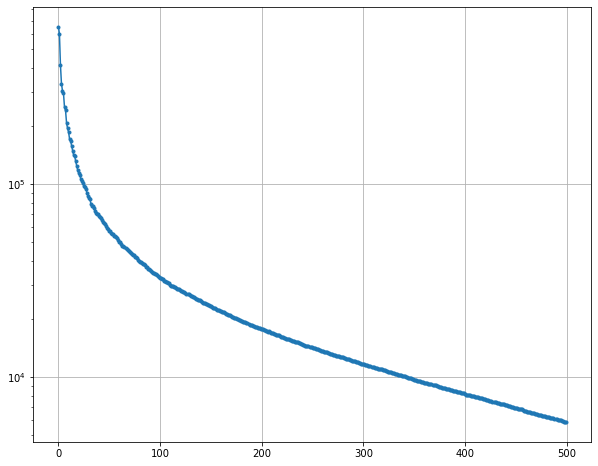

In [147]:
plt.figure(figsize=(10,8))
plt.plot(B_eigs, marker='.')
#plt.plot(eigs_large, marker='.')
plt.yscale('log')
plt.grid()

In [64]:
mode = B_v[:,-1]

In [65]:
m = mode.reshape(2, 196608)

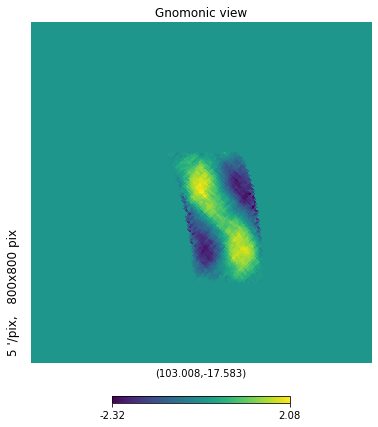

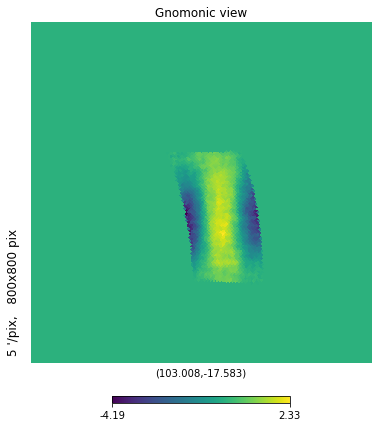

In [66]:
lon,lat = hp.pix2ang(128, np.argmax(m[0]), lonlat=True)
hp.gnomview(m[0], rot=(lon, lat), xsize=800, reso=5)
hp.gnomview(m[1], rot=(lon, lat), xsize=800, reso=5)